## Contents

1. [Preprocessing Tweets](#preprocessing-tweets)

In [1]:
import pandas as pd
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tag import pos_tag
from nltk.corpus import wordnet
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('punkt');

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing Tweets

In [2]:
df = pd.read_csv("data/tweets.csv", encoding='ISO-8859-1')

df.columns = ["unprocessed_tweet", "product", "emotion"]

df.head(3)

,unprocessed_tweet,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


In [3]:
text = df["unprocessed_tweet"]
text

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [4]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
stop_words = [i.replace("'", '') for i in stop_words]

stop_words[-5:]
top_words = ['sxsw', 'mention', 'link', 'rt']
stop_words = stop_words + top_words

In [5]:
ex = "[^a-zA-Z\s]"

text = text.str.replace(ex, "", regex=True)
text = text.str.lower()
text

0       wesley i have a g iphone after  hrs tweeting a...
1       jessedee know about fludapp  awesome ipadiphon...
2       swonderlin can not wait for ipad  also they sh...
3       sxsw i hope this years festival isnt as crashy...
4       sxtxstate great stuff on fri sxsw marissa maye...
                              ...                        
9088                            ipad everywhere sxsw link
9089    wave buzz rt mention we interrupt your regular...
9090    googles zeiger a physician never reported pote...
9091    some verizon iphone customers complained their...
9092    rt mention google tests checkin offers at sxsw...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [6]:
from nltk.tokenize import word_tokenize

tokenized_text = text.apply(lambda t: word_tokenize(str(t)))
tokenized_text

0       [wesley, i, have, a, g, iphone, after, hrs, tw...
1       [jessedee, know, about, fludapp, awesome, ipad...
2       [swonderlin, can, not, wait, for, ipad, also, ...
3       [sxsw, i, hope, this, years, festival, isnt, a...
4       [sxtxstate, great, stuff, on, fri, sxsw, maris...
                              ...                        
9088                       [ipad, everywhere, sxsw, link]
9089    [wave, buzz, rt, mention, we, interrupt, your,...
9090    [googles, zeiger, a, physician, never, reporte...
9091    [some, verizon, iphone, customers, complained,...
9092    [rt, mention, google, tests, checkin, offers, ...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [7]:
filtered_text = tokenized_text.apply(lambda x: [word for word in x if word not in stop_words])
filtered_text = filtered_text.apply(lambda x: [word for word in x if len(word) > 1])
filtered_text

0       [wesley, iphone, hrs, tweeting, riseaustin, de...
1       [jessedee, know, fludapp, awesome, ipadiphone,...
2                    [swonderlin, wait, ipad, also, sale]
3       [hope, years, festival, crashy, years, iphone,...
4       [sxtxstate, great, stuff, fri, marissa, mayer,...
                              ...                        
9088                                   [ipad, everywhere]
9089    [wave, buzz, interrupt, regularly, scheduled, ...
9090    [googles, zeiger, physician, never, reported, ...
9091    [verizon, iphone, customers, complained, time,...
9092                     [google, tests, checkin, offers]
Name: unprocessed_tweet, Length: 9093, dtype: object

In [8]:
tagged_text = filtered_text.apply(lambda x: pos_tag(x))
tagged_text

0       [(wesley, NN), (iphone, NN), (hrs, NN), (tweet...
1       [(jessedee, NN), (know, VBP), (fludapp, VBZ), ...
2       [(swonderlin, NN), (wait, NN), (ipad, NN), (al...
3       [(hope, NN), (years, NNS), (festival, JJ), (cr...
4       [(sxtxstate, NN), (great, JJ), (stuff, NN), (f...
                              ...                        
9088                       [(ipad, NN), (everywhere, RB)]
9089    [(wave, NN), (buzz, NN), (interrupt, VBP), (re...
9090    [(googles, NNS), (zeiger, RBR), (physician, JJ...
9091    [(verizon, NN), (iphone, NN), (customers, NNS)...
9092    [(google, NN), (tests, NNS), (checkin, VBP), (...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [9]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatized_text = tagged_text.apply(
    lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in x]
)

lemmatized_str = lemmatized_text.apply(lambda x: ' '.join(x))

lemmatized_str

0       wesley iphone hr tweet riseaustin dead need up...
1       jessedee know fludapp awesome ipadiphone app l...
2                          swonderlin wait ipad also sale
3               hope year festival crashy year iphone app
4       sxtxstate great stuff fri marissa mayer google...
                              ...                        
9088                                      ipad everywhere
9089    wave buzz interrupt regularly schedule geek pr...
9090    google zeiger physician never report potential...
9091    verizon iphone customer complain time fell bac...
9092                            google test checkin offer
Name: unprocessed_tweet, Length: 9093, dtype: object

In [10]:
lemmatized_text

0       [wesley, iphone, hr, tweet, riseaustin, dead, ...
1       [jessedee, know, fludapp, awesome, ipadiphone,...
2                    [swonderlin, wait, ipad, also, sale]
3       [hope, year, festival, crashy, year, iphone, app]
4       [sxtxstate, great, stuff, fri, marissa, mayer,...
                              ...                        
9088                                   [ipad, everywhere]
9089    [wave, buzz, interrupt, regularly, schedule, g...
9090    [google, zeiger, physician, never, report, pot...
9091    [verizon, iphone, customer, complain, time, fe...
9092                       [google, test, checkin, offer]
Name: unprocessed_tweet, Length: 9093, dtype: object

In [11]:
df["processed_tweet"] = lemmatized_str
df.head()

,unprocessed_tweet,product,emotion,processed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...


In [12]:
df.to_csv("data/processed_tweets.csv")

In [13]:
df_binary = df.copy()
df_binary = df_binary[df_binary["emotion"].isin(["Negative emotion", "Positive emotion"])]

df_binary["emotion_encoded"] = df_binary["emotion"].replace("Negative emotion", 0).replace("Positive emotion", 1)
df_binary.to_csv("data/processed_tweets_binary.csv")

In [14]:
df_binary

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...,1
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,pr guy convince switch back iphone great cover...,1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,quotpapyrussort like ipadquot nice lol lavelle,1
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,diller say google tv quotmight run playstation...,0
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,ive always use camera iphone bc image stabiliz...,1


In [15]:
df_binary['emotion_encoded'].value_counts()

1    2978
0     570
Name: emotion_encoded, dtype: int64

In [16]:
X = df_binary['processed_tweet']
y = df_binary['emotion_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [17]:
bin_forest_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words)),
    ('rf', RandomForestClassifier(random_state=42))
])

In [18]:
bin_forest_pipe.fit(X_train, y_train)

y_pred_forest = bin_forest_pipe.predict(X_test)
forest_test_acc = accuracy_score(y_test, y_pred_forest)
forest_test_acc

0.8577464788732394

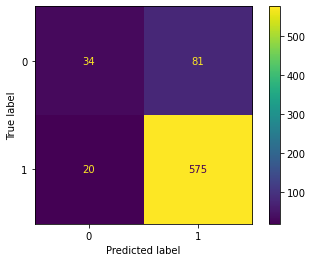

In [19]:
cfm_forest = confusion_matrix(y_test, y_pred_forest)
ConfusionMatrixDisplay(cfm_forest).plot()

In [20]:
forest_score = cross_val_score(bin_forest_pipe, X_train, y_train, cv=5)
forest_score

array([0.85211268, 0.84859155, 0.8556338 , 0.86419753, 0.85361552])

In [21]:
bin_forest_pipe_grid = Pipeline([
    ('tf', TfidfVectorizer(stop_words=stop_words)),
    ('rf', RandomForestClassifier(random_state=42))
    
])

In [64]:
forest_param_grid = {
    'tf__min_df': [.01, .02, .03],
    'tf__max_df': [.88, .90, .92],
    'tf__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [86, 88, 90],
    'rf__min_samples_split': [10, 20, 30],
    'rf__class_weight': [None, 'balanced', 'balanced_subsample']
    
}

In [66]:
bin_forest_grid = GridSearchCV(bin_forest_pipe_grid, forest_param_grid, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')
bin_forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    'youre',
                                                                    'youve',
                                                                    'youll',
                                                                    'youd',
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'shes',
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', 'its',
                                                                    'its',
                                                                    'itself', ...])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'rf__class_weight': [None, 'balanced',
                                              'balanced_subsample'],
                         'rf__min_samples_split': [10, 20, 30],
                         'rf__n_estimators': [86, 88, 90],
                         'tf__max_df': [0.88, 0.9, 0.92],
                         'tf__min_df': [0.01, 0.02, 0.03],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [71]:
print(bin_forest_grid.best_estimator_)
print(bin_forest_grid.best_params_)
print(bin_forest_grid.best_score_)

Pipeline(steps=[('tf',
                 TfidfVectorizer(max_df=0.88, min_df=0.01,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...])),
                ('rf',
                 RandomForestClassifier(min_samples_split=10, n_estimators=86,
                                        random_state=42))])
{'rf__class_weight': None, 'rf__min_samples_split': 10, 'rf__n_estimators': 86, 'tf__max_df': 0.88, 'tf__min_df': 0.01, 'tf__ngram_range': (

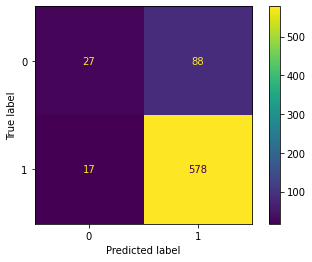

In [72]:
y_pred_forest_grid = bin_forest_grid.predict(X_test)
cfm_forest = confusion_matrix(y_test, y_pred_forest_grid)
ConfusionMatrixDisplay(cfm_forest).plot()

In [70]:
forest_score = cross_val_score(bin_forest_grid, X_train, y_train, cv=5)
forest_score

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


array([0.84859155, 0.84507042, 0.85387324, 0.85890653, 0.84479718])

---

In [73]:
bin_log_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words)),
    ('lr', LogisticRegression(random_state=42))
])

In [74]:
bin_log_pipe.fit(X_train, y_train)

y_pred_log = bin_log_pipe.predict(X_test)
log_test_acc = accuracy_score(y_test, y_pred_log)
log_test_acc

0.8352112676056338

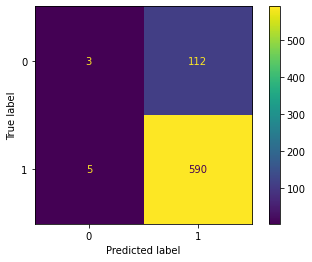

In [75]:
cfm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cfm_log).plot()

In [76]:
log_score = cross_val_score(bin_log_pipe, X_train, y_train, cv=5)
log_score

array([0.83978873, 0.84683099, 0.83978873, 0.84479718, 0.84303351])

In [77]:
bin_log_pipe_grid = Pipeline([
    ('tf', TfidfVectorizer(stop_words=stop_words)),
    ('lr', LogisticRegression(random_state=42))
])

In [78]:
log_param_grid = {
    'tf__min_df': [.01, .02, .03],
    'tf__max_df': [.88, .90, .92],
    'tf__ngram_range': [(1,1), (1,2), (1,3)],
    'lr__penalty': [None, 'l2', 'l1'],
    'lr__class_weight': [None, 'balanced'],
    'lr__solver': ['lbfgs', 'liblinear'],
    'lr__max_iter': [10, 15, 20]
}

In [58]:
bin_log_grid = GridSearchCV(bin_log_pipe_grid, log_param_grid, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')
bin_log_grid.fit(X_train, y_train)

[LibLinear]

/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    'youre',
                                                                    'youve',
                                                                    'youll',
                                                                    'youd',
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'shes',
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', 'its',
                                                                    'its',
                                                                    'itself', ...])),
                                       ('lr',
                                        LogisticRegression(random_state=42,
                                                           verbose=1))]),
             n_jobs=-2,
             param_grid={'lr__class_weight': [None, 'balanced'],
                         'lr__max_iter': [10, 15, 20],
                         'lr__penalty': [None, 'l2', 'l1'],
                         'lr__solver': ['lbfgs', 'liblinear'],
                         'tf__max_df': [0.88, 0.9, 0.92],
                         'tf__min_df': [0.01, 0.02, 0.03],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [59]:
print(bin_log_grid.best_params_)
print(bin_log_grid.best_score_)

{'lr__class_weight': None, 'lr__max_iter': 10, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'tf__max_df': 0.88, 'tf__min_df': 0.01, 'tf__ngram_range': (1, 1)}
0.8442556574011973


In [79]:


y_pred_log_grid = bin_log_grid.predict(X_test)
log_test_acc = accuracy_score(y_test, y_pred_log_grid)
log_test_acc

0.8408450704225352

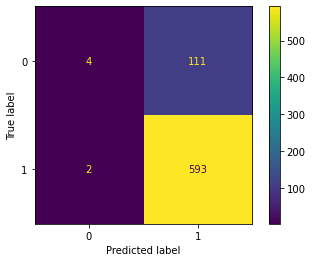

In [80]:
cfm_log = confusion_matrix(y_test, y_pred_log_grid)
ConfusionMatrixDisplay(cfm_log).plot()

In [ ]:
log_score = cross_val_score(bin_log_grid, X_train, y_train, cv=5)
log_score

/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

[LibLinear]

/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

[LibLinear]

/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

[LibLinear]

In [35]:
tf = TfidfVectorizer(min_df = .01, max_df = .9)

X_train_tf = tf.fit_transform(X_train.values)
X_train_tf = X_train_tf.toarray()
X_test_tf = tf.transform(X_test.values)
X_test_tf = X_test_tf.toarray()

In [36]:
nb_model = GaussianNB()

In [37]:
nb_model.fit(X_train_tf, y_train)

y_pred_nb = nb_model.predict(X_test_tf)
nb_test_acc = accuracy_score(y_test, y_pred_nb)
nb_test_acc

0.43661971830985913

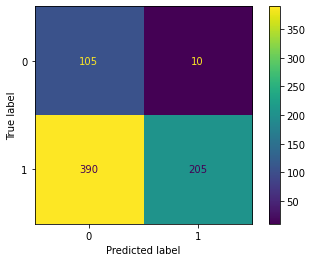

In [38]:
cfm_nb = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(cfm_nb).plot()

In [39]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.21      0.91      0.34       115
           1       0.95      0.34      0.51       595

    accuracy                           0.44       710
   macro avg       0.58      0.63      0.43       710
weighted avg       0.83      0.44      0.48       710



In [40]:
nb_pipe = Pipeline([
    ('nb', GaussianNB())
])

nb_param_grid = {
    'nb__var_smoothing': [1e-8, 1e-9, 1e-10]
}

In [41]:
nb_grid = GridSearchCV(nb_pipe, nb_param_grid, cv=5, n_jobs=2)
nb_grid.fit(X_train_tf, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('nb', GaussianNB())]), n_jobs=2,
             param_grid={'nb__var_smoothing': [1e-08, 1e-09, 1e-10]})

In [42]:
print(nb_grid.best_params_)
print(nb_grid.best_score_)

{'nb__var_smoothing': 1e-08}
0.43517152296495015


In [66]:
df_binary['list_tokens'] = lemmatized_text

In [43]:
df_binary

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded,list_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...,0,"[wesley, iphone, hr, tweet, riseaustin, dead, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...,1,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale sxsw,1,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw hope year festival crashy year iphone app...,0,"[sxsw, hope, year, festival, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri sxsw marissa mayer g...,1,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."
...,...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,mention pr guy convince switch back iphone gre...,1,"[mention, pr, guy, convince, switch, back, iph..."
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,quotpapyrussort like ipadquot nice lol sxsw la...,1,"[quotpapyrussort, like, ipadquot, nice, lol, s..."
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,diller say google tv quotmight run playstation...,0,"[diller, say, google, tv, quotmight, run, play..."
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,ive always use camera iphone bc image stabiliz...,1,"[ive, always, use, camera, iphone, bc, image, ..."


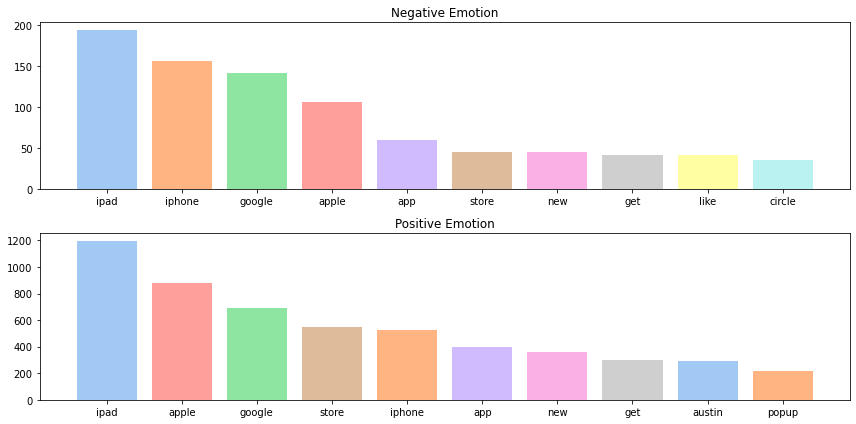

In [67]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 6))

plotted_words_and_colors = {}

color_palette = sns.color_palette('pastel', n_colors = 38)

data_by_emotion = [y for _, y in df_binary.groupby('emotion_encoded', as_index=False)]
for idx, emotion_df in enumerate(data_by_emotion):
    all_words_in_emotion = emotion_df.list_tokens.explode()
    top_10 = all_words_in_emotion.value_counts()[:10]
    
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
             new_color = color_palette.pop(0)
             plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
            
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(emotion_df.iloc[0].emotion.title())
    
fig.tight_layout()

In [52]:
top_10

sxsw       3111
mention    2176
link       1216
ipad       1196
rt          922
apple       878
google      692
store       549
iphone      522
app         395
Name: list_tokens, dtype: int64